Import

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from pathlib import Path
from sklearn.cluster import KMeans
import scipy.stats as stats
from sklearn.inspection import permutation_importance

Pre-Processing

In [ ]:
def preprocess_emissions_data(emissions_df):
    """
    Preprocess the emissions dataset
    """
    print("\nPreprocessing emissions data...")

    # Create pivot table for all sectors and fuels
    emissions_pivot = emissions_df.pivot_table(
        index=['year', 'state-name', 'sector-name'],
        columns='fuel-name',
        values='value',
        aggfunc='first'
    ).reset_index()

    # Get only the total emissions for each state and year
    total_emissions = emissions_df[
        (emissions_df['sector-name'] == 'Total carbon dioxide emissions from all sectors') &
        (emissions_df['fuel-name'] == 'All Fuels')
    ][['year', 'state-name', 'value']].rename(
        columns={'value': 'total_emissions', 'state-name': 'state'}
    )

    # Get sector-specific emissions
    sectors = ['Residential', 'Commercial', 'Transportation', 'Industrial', 'Electric Power']
    sector_emissions = {}

    for sector in sectors:
        sector_data = emissions_df[
            (emissions_df['sector-name'] == f'{sector} carbon dioxide emissions') &
            (emissions_df['fuel-name'] == 'All Fuels')
        ][['year', 'state-name', 'value']]

        if not sector_data.empty:
            sector_emissions[sector] = sector_data

    # Combine all sector data
    combined_sectors = total_emissions.copy()
    for sector, data in sector_emissions.items():
        sector_pivot = data.rename(columns={'value': f'{sector.lower()}_emissions', 'state-name': 'state'})
        combined_sectors = pd.merge(
            combined_sectors,
            sector_pivot,
            on=['year', 'state'],
            how='left'
        )

    print(f"Processed emissions shape: {combined_sectors.shape}")
    return combined_sectors

def preprocess_income_data(income_df):
    """
    Preprocess the income dataset
    """
    print("\nPreprocessing income data...")

    # Get year columns (numeric columns from 1970 onwards to match emissions data)
    year_cols = [col for col in income_df.columns if str(col).isdigit() and int(col) >= 1970]

    # Extract population data
    pop_data = income_df[income_df['Description'] == 'Population (persons) 1/']
    pop_melted = pd.melt(
        pop_data,
        id_vars=['GeoName'],
        value_vars=year_cols,
        var_name='year',
        value_name='population'
    )

    # Extract income data
    income_data = income_df[income_df['Description'] == 'Per capita personal income (dollars) 2/']
    income_melted = pd.melt(
        income_data,
        id_vars=['GeoName'],
        value_vars=year_cols,
        var_name='year',
        value_name='per_capita_income'
    )

    # Combine population and income data
    combined_data = pd.merge(
        pop_melted,
        income_melted,
        on=['GeoName', 'year']
    )

    # Clean up state names and convert year to numeric
    combined_data = combined_data.rename(columns={'GeoName': 'state'})
    combined_data['year'] = pd.to_numeric(combined_data['year'])
    combined_data['population'] = pd.to_numeric(combined_data['population'], errors='coerce')
    combined_data['per_capita_income'] = pd.to_numeric(combined_data['per_capita_income'], errors='coerce')

    # Remove asterisks from state names and strip whitespace
    combined_data['state'] = combined_data['state'].str.replace(' \*', '').str.strip()

    print(f"Processed income shape: {combined_data.shape}")
    return combined_data

def combine_datasets(emissions_df, income_df):
    """
    Combine the preprocessed emissions and income datasets
    """
    print("\nCombining datasets...")

    # Merge on state and year
    combined_df = pd.merge(
        emissions_df,
        income_df,
        on=['state', 'year'],
        how='inner'
    )

    # Calculate emissions per capita
    combined_df['emissions_per_capita'] = combined_df['total_emissions'] / combined_df['population']

    print(f"Final combined shape: {combined_df.shape}")
    return combined_df

def main():
    """
    Main preprocessing pipeline
    """
    try:
        # Load data
        emissions_df = pd.read_csv('emissions.csv')
        income_df = pd.read_csv('income_pop_capitaI__ALL_AREAS_1929_2023.csv')

        # Process each dataset
        processed_emissions = preprocess_emissions_data(emissions_df)
        processed_income = preprocess_income_data(income_df)

        # Combine datasets
        final_df = combine_datasets(processed_emissions, processed_income)

        # Save processed data
        final_df.to_csv('processed_emissions_income.csv', index=False)

        # Print summary
        print("\nFinal Dataset Summary:")
        print(f"Year range: {final_df['year'].min()} - {final_df['year'].max()}")
        print(f"Number of states: {final_df['state'].nunique()}")
        print(f"Total observations: {len(final_df)}")

        return final_df

    except Exception as e:
        print(f"Error in processing: {str(e)}")
        return None

if __name__ == "__main__":
    final_df = main()

    if final_df is not None:
        print("\nSample of processed data:")
        print(final_df.head())


Preprocessing emissions data...
Processed emissions shape: (2704, 8)

Preprocessing income data...
Processed income shape: (3240, 4)

Combining datasets...
Final combined shape: (2600, 11)

Final Dataset Summary:
Year range: 1970 - 2021
Number of states: 50
Total observations: 2600

Sample of processed data:
   year       state  total_emissions  residential_emissions  \
0  1970     Alabama       102.646851               4.336656   
1  1970     Arizona        24.906189               1.917605   
2  1970    Arkansas        36.178889               4.789228   
3  1970  California       294.372200              32.381940   
4  1970    Colorado        43.017559               5.398918   

   commercial_emissions  transportation_emissions  industrial_emissions  \
0              2.934710                 18.787545             39.243383   
1              1.501632                 13.356809              4.003728   
2              2.572943                 11.580404             11.184168   
3         

Pre-Analysis

<ipython-input-16-8daf42ecbbc8>:57: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  emission_shares = df.groupby('income_quintile')['emissions_per_capita'].mean()
<ipython-input-16-8daf42ecbbc8>:60: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlation_by_year = df.groupby('year').apply(
<ipython-input-16-8daf42ecbbc8>:100: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to 


Analysis Results Summary

1. Income-Emissions Inequality Metrics
      year  income_gini  emissions_gini  p90_p10_ratio
47  2017.0     0.088141        0.341516       1.497307
48  2018.0     0.088334        0.341346       1.492156
49  2019.0     0.087495        0.335230       1.519435
50  2020.0     0.085736        0.346172       1.494512
51  2021.0     0.082643        0.341147       1.439152

2. Emission Shares by Income Quintile
income_quintile
Q1    0.000023
Q2    0.000024
Q3    0.000025
Q4    0.000023
Q5    0.000020
Name: emissions_per_capita, dtype: float64

3. Policy Insights
1. Increasing trend in emissions inequality suggests need for progressive environmental policies


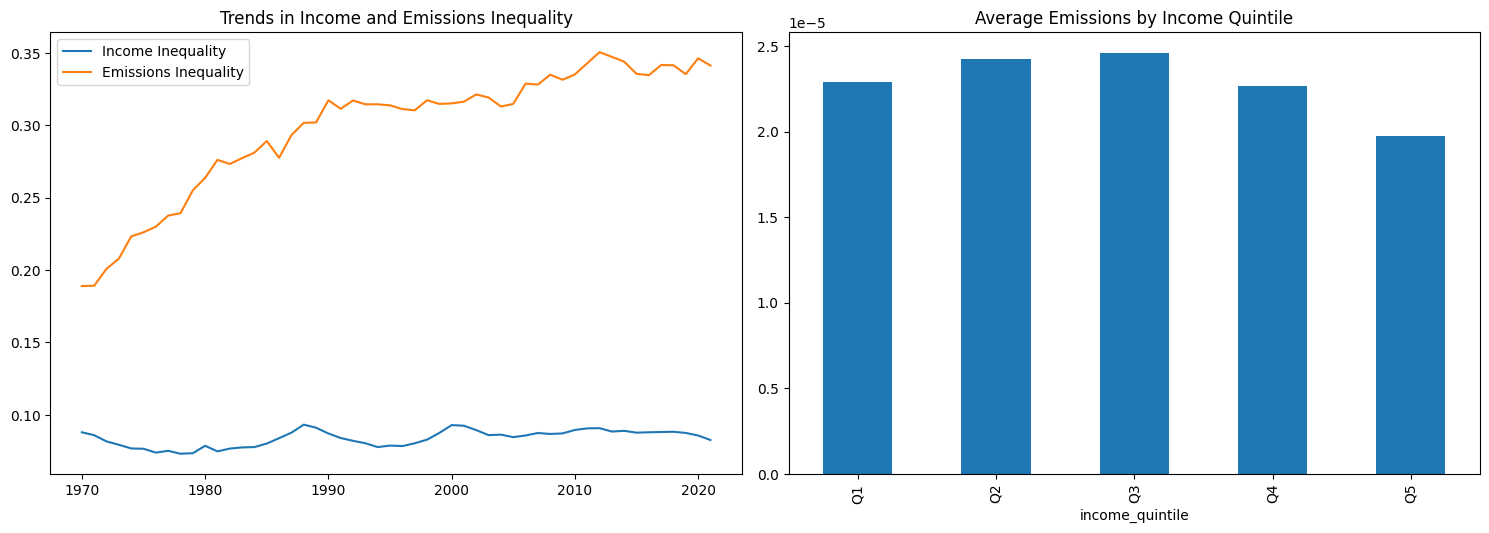

In [ ]:
def calculate_gini(x):
    """
    Calculate the Gini coefficient
    x: numpy array or list of values
    """
    x = np.array(x)
    if len(x) <= 1 or np.all(x == 0):
        return 0

    # Sort values in ascending order
    sorted_x = np.sort(x)
    n = len(x)
    cumsum = np.cumsum(sorted_x)

    # Calculate Gini coefficient
    return (n + 1 - 2 * np.sum(cumsum) / cumsum[-1]) / n

def calculate_inequality_metrics(df, year):
    """Calculate inequality metrics for a given year"""
    year_data = df[df['year'] == year].copy()

    # Calculate Gini coefficient for income
    income_gini = calculate_gini(year_data['per_capita_income'])

    # Calculate emissions concentration (similar to Gini but for emissions)
    emissions_gini = calculate_gini(year_data['emissions_per_capita'])

    # Calculate percentile ratios for income
    income_sorted = np.sort(year_data['per_capita_income'])
    p90_p10_ratio = income_sorted[int(0.9 * len(income_sorted))] / income_sorted[int(0.1 * len(income_sorted))]

    return pd.Series({
        'year': year,
        'income_gini': income_gini,
        'emissions_gini': emissions_gini,
        'p90_p10_ratio': p90_p10_ratio
    })

def analyze_emissions_inequality(df):
    """Analyze the relationship between income inequality and emissions"""

    # Calculate inequality metrics for each year
    years = sorted(df['year'].unique())
    inequality_metrics = pd.DataFrame([calculate_inequality_metrics(df, year) for year in years])

    # Perform clustering analysis
    scaler = StandardScaler()
    features = ['per_capita_income', 'emissions_per_capita']
    scaled_data = scaler.fit_transform(df[features])

    # Use KMeans to identify high/medium/low emission-income groups
    kmeans = KMeans(n_clusters=3, random_state=42)
    df['cluster'] = kmeans.fit_predict(scaled_data)

    # Calculate emission shares by income quintile
    df['income_quintile'] = pd.qcut(df['per_capita_income'], q=5, labels=['Q1', 'Q2', 'Q3', 'Q4', 'Q5'])
    emission_shares = df.groupby('income_quintile')['emissions_per_capita'].mean()

    # Time series analysis of inequality-emissions relationship
    correlation_by_year = df.groupby('year').apply(
        lambda x: x['per_capita_income'].corr(x['emissions_per_capita'])
    )

    return {
        'inequality_metrics': inequality_metrics,
        'emission_shares': emission_shares,
        'correlation_by_year': correlation_by_year,
        'clustered_data': df
    }

def analyze_state_patterns(df):
    """Analyze patterns at the state level"""

    # Calculate average emissions and income growth rates
    state_metrics = df.groupby('state').agg({
        'emissions_per_capita': ['mean', 'std'],
        'per_capita_income': ['mean', 'std']
    })

    # Calculate efficiency metrics (emissions per dollar of income)
    df['emission_efficiency'] = df['emissions_per_capita'] / df['per_capita_income']
    efficiency_trends = df.groupby('year')['emission_efficiency'].mean()

    return {
        'state_metrics': state_metrics,
        'efficiency_trends': efficiency_trends
    }

def generate_policy_insights(analysis_results):
    """Generate policy insights based on analysis results"""

    insights = []

    # Analyze income-emissions elasticity
    recent_data = analysis_results['clustered_data'][
        analysis_results['clustered_data']['year'] >= 2000
    ]

    # Calculate emission intensity by income group
    emission_intensity = recent_data.groupby('income_quintile').agg({
        'emissions_per_capita': 'mean',
        'per_capita_income': 'mean'
    })
    emission_intensity['intensity'] = emission_intensity['emissions_per_capita'] / emission_intensity['per_capita_income']

    # Generate insights based on patterns
    if emission_intensity.loc['Q5', 'intensity'] > emission_intensity.loc['Q1', 'intensity']:
        insights.append("Higher income groups show higher emission intensity, suggesting potential for targeted reduction policies")

    # Analyze trends in inequality metrics
    inequality_trend = stats.linregress(
        analysis_results['inequality_metrics']['year'],
        analysis_results['inequality_metrics']['emissions_gini']
    )

    if inequality_trend.slope > 0:
        insights.append("Increasing trend in emissions inequality suggests need for progressive environmental policies")

    return insights

def main(processed_data_path):
    """Main analysis pipeline"""

    # Load processed data
    df = pd.read_csv(processed_data_path)

    # Perform analyses
    emissions_inequality_results = analyze_emissions_inequality(df)
    state_pattern_results = analyze_state_patterns(df)

    # Generate policy insights
    insights = generate_policy_insights(emissions_inequality_results)

    # Create summary report
    print("\nAnalysis Results Summary")
    print("========================")

    print("\n1. Income-Emissions Inequality Metrics")
    print(emissions_inequality_results['inequality_metrics'].tail())

    print("\n2. Emission Shares by Income Quintile")
    print(emissions_inequality_results['emission_shares'])

    print("\n3. Policy Insights")
    for i, insight in enumerate(insights, 1):
        print(f"{i}. {insight}")

    # Create visualizations
    plt.figure(figsize=(15, 10))

    # Plot 1: Inequality trends
    plt.subplot(2, 2, 1)
    plt.plot(emissions_inequality_results['inequality_metrics']['year'],
             emissions_inequality_results['inequality_metrics']['income_gini'],
             label='Income Inequality')
    plt.plot(emissions_inequality_results['inequality_metrics']['year'],
             emissions_inequality_results['inequality_metrics']['emissions_gini'],
             label='Emissions Inequality')
    plt.title('Trends in Income and Emissions Inequality')
    plt.legend()

    # Plot 2: Emissions by Income Quintile
    plt.subplot(2, 2, 2)
    emissions_inequality_results['emission_shares'].plot(kind='bar')
    plt.title('Average Emissions by Income Quintile')

    plt.tight_layout()
    plt.savefig('inequality_emissions_analysis.png')

    return {
        'emissions_inequality': emissions_inequality_results,
        'state_patterns': state_pattern_results,
        'insights': insights
    }

if __name__ == "__main__":
    results = main('processed_emissions_income.csv')
    plt.show()

Random Forest

Loading data...
Preparing features...
Training model...
Preparing features for Random Forest...
Training set size: (2295, 60), Test set size: (245, 60)

Random Forest Model Results

Model Performance Metrics:
R² Score: 0.891
Mean Squared Error: 0.000
Mean Absolute Error: 0.000

Cross-validation Scores:
Mean CV Score: 0.841
CV Score Std: 0.124

Top 5 Most Important Features:
                feature  importance
59        state_Wyoming    0.546359
42   state_North Dakota    0.134994
57  state_West Virginia    0.097283
9           region_High    0.045071
26      state_Louisiana    0.042969


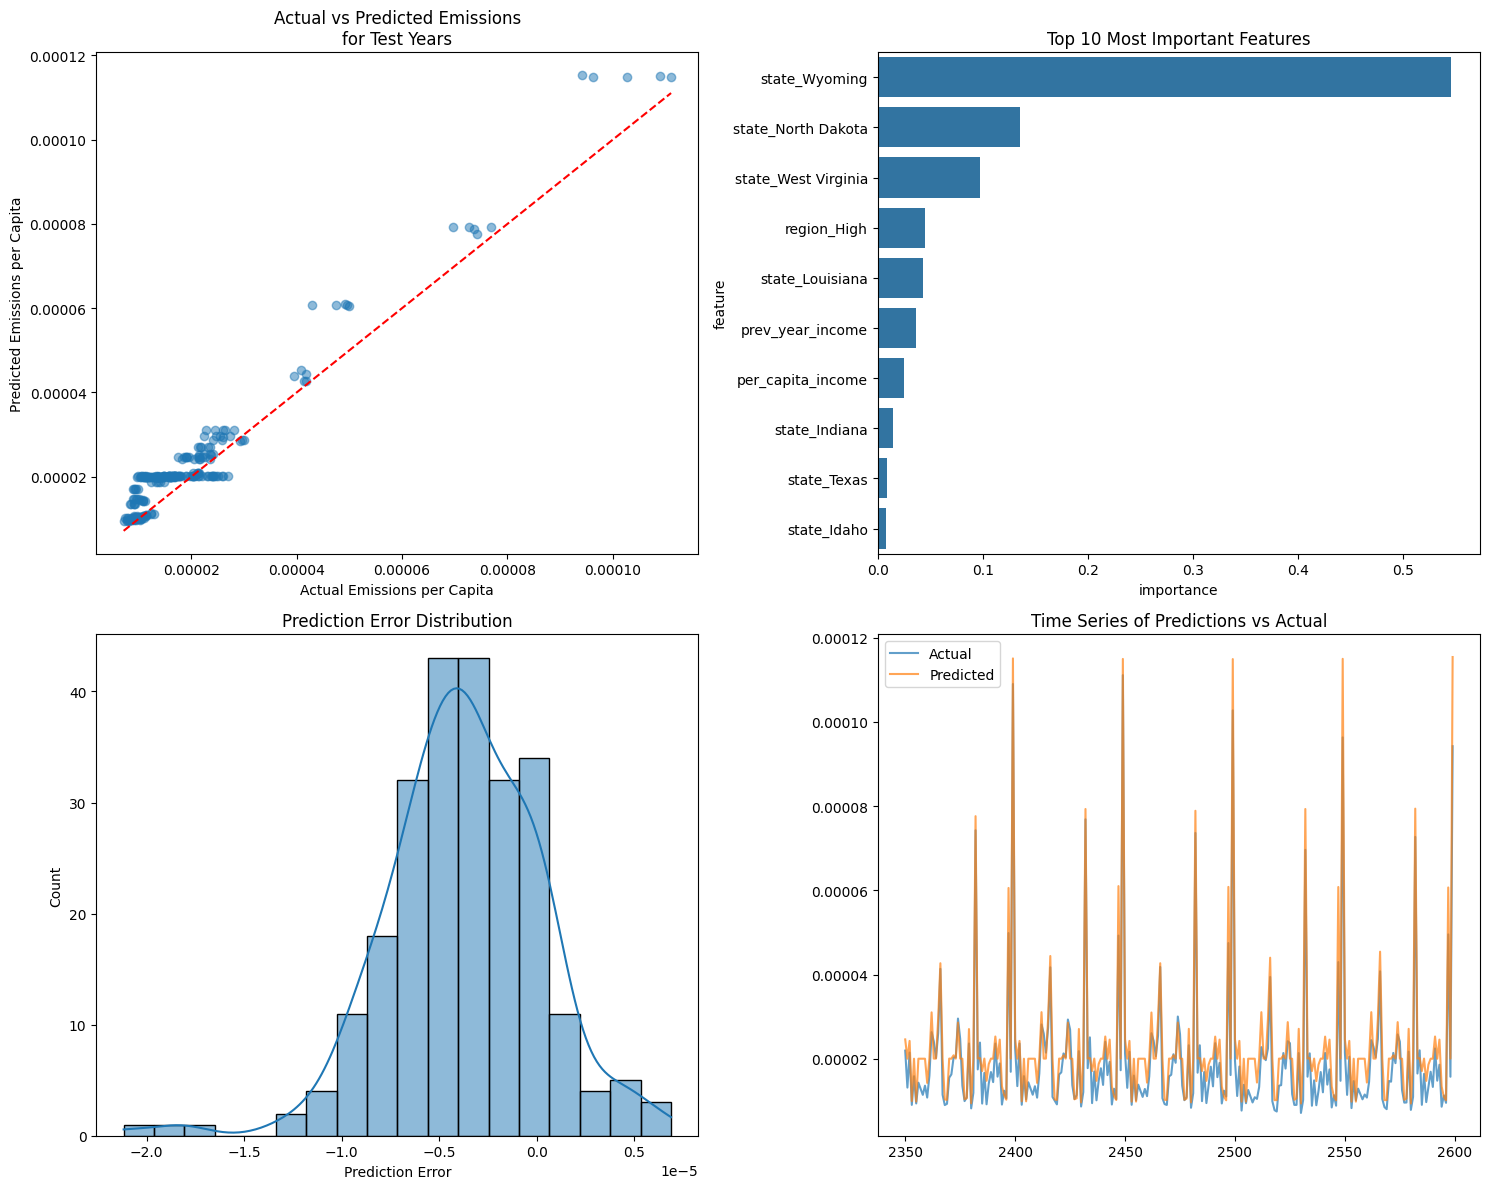

In [ ]:
def prepare_features(df):
    """
    Prepare features without data leakage
    """
    # Create time-based features
    df['decade'] = (df['year'] // 10) * 10

    # Create lagged features using previous year's data
    df_sorted = df.sort_values(['state', 'year'])
    df['prev_year_income'] = df_sorted.groupby('state')['per_capita_income'].shift(1)
    df['income_growth'] = (df['per_capita_income'] - df['prev_year_income']) / df['prev_year_income']

    # Create regional features
    df['region'] = pd.qcut(df.groupby('state')['per_capita_income'].transform('mean'),
                          q=5, labels=['Low', 'Medium-Low', 'Medium', 'Medium-High', 'High'])

    # Population density might affect emissions
    if 'population' in df.columns:
        df['population_density'] = df['population'] / df.groupby('state')['population'].transform('mean')

    # Remove rows with NaN from lagged features
    df = df.dropna()

    return df

def train_random_forest(df):
    """
    Train and evaluate random forest model with proper feature selection
    """
    print("Preparing features for Random Forest...")

    # Select features that don't cause data leakage
    feature_columns = [
        'per_capita_income',
        'prev_year_income',
        'income_growth',
        'decade',
        'population_density'
    ]

    # Add categorical variables
    df_encoded = pd.get_dummies(df, columns=['region', 'state'])
    feature_columns.extend([col for col in df_encoded.columns if col.startswith(('region_', 'state_'))])

    X = df_encoded[feature_columns]
    y = df_encoded['emissions_per_capita']

    # Use time series split instead of random split
    tscv = TimeSeriesSplit(n_splits=5)

    # Create train/test split using the most recent years as test set
    train_years = df['year'].sort_values().unique()[:-5]  # Use all but last 5 years for training
    test_years = df['year'].sort_values().unique()[-5:]   # Use last 5 years for testing

    X_train = X[df['year'].isin(train_years)]
    X_test = X[df['year'].isin(test_years)]
    y_train = y[df['year'].isin(train_years)]
    y_test = y[df['year'].isin(test_years)]

    print(f"Training set size: {X_train.shape}, Test set size: {X_test.shape}")

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Train model with adjusted parameters
    rf_model = RandomForestRegressor(
        n_estimators=200,
        max_depth=10,
        min_samples_split=10,
        min_samples_leaf=5,
        random_state=42
    )

    rf_model.fit(X_train_scaled, y_train)
    y_pred = rf_model.predict(X_test_scaled)

    # Calculate feature importance
    importance = pd.DataFrame({
        'feature': feature_columns,
        'importance': rf_model.feature_importances_
    }).sort_values('importance', ascending=False)

    # Perform time series cross-validation
    cv_scores = []
    for train_idx, val_idx in tscv.split(X_train_scaled):
        cv_train_X = X_train_scaled[train_idx]
        cv_train_y = y_train.iloc[train_idx]
        cv_val_X = X_train_scaled[val_idx]
        cv_val_y = y_train.iloc[val_idx]

        rf_model.fit(cv_train_X, cv_train_y)
        cv_scores.append(r2_score(cv_val_y, rf_model.predict(cv_val_X)))

    return {
        'model': rf_model,
        'metrics': {
            'r2': r2_score(y_test, y_pred),
            'mse': mean_squared_error(y_test, y_pred),
            'mae': mean_absolute_error(y_test, y_pred)
        },
        'feature_importance': importance,
        'cv_scores': cv_scores,
        'predictions': y_pred,
        'actual': y_test,
        'test_years': test_years
    }

def analyze_results(results):
    """
    Analyze and visualize model results
    """
    plt.figure(figsize=(15, 12))

    # Plot 1: Actual vs Predicted with Year-based Coloring
    plt.subplot(2, 2, 1)
    plt.scatter(results['actual'], results['predictions'], alpha=0.5)
    plt.plot([results['actual'].min(), results['actual'].max()],
             [results['actual'].min(), results['actual'].max()], 'r--')
    plt.xlabel('Actual Emissions per Capita')
    plt.ylabel('Predicted Emissions per Capita')
    plt.title('Actual vs Predicted Emissions\nfor Test Years')

    # Plot 2: Top 10 Feature Importance
    plt.subplot(2, 2, 2)
    top_features = results['feature_importance'].head(10)
    sns.barplot(x='importance', y='feature', data=top_features)
    plt.title('Top 10 Most Important Features')

    # Plot 3: Prediction Error Distribution
    plt.subplot(2, 2, 3)
    errors = results['actual'] - results['predictions']
    sns.histplot(errors, kde=True)
    plt.title('Prediction Error Distribution')
    plt.xlabel('Prediction Error')

    # Plot 4: Time Series of Predictions vs Actual
    plt.subplot(2, 2, 4)
    plt.plot(results['actual'].index, results['actual'], label='Actual', alpha=0.7)
    plt.plot(results['actual'].index, results['predictions'], label='Predicted', alpha=0.7)
    plt.title('Time Series of Predictions vs Actual')
    plt.legend()

    plt.tight_layout()
    return plt.gcf()

def main():
    print("Loading data...")
    df = pd.read_csv('processed_emissions_income.csv')

    print("Preparing features...")
    df_prepared = prepare_features(df)

    print("Training model...")
    results = train_random_forest(df_prepared)

    print("\nRandom Forest Model Results")
    print("==========================")
    print(f"\nModel Performance Metrics:")
    print(f"R² Score: {results['metrics']['r2']:.3f}")
    print(f"Mean Squared Error: {results['metrics']['mse']:.3f}")
    print(f"Mean Absolute Error: {results['metrics']['mae']:.3f}")

    print(f"\nCross-validation Scores:")
    print(f"Mean CV Score: {np.mean(results['cv_scores']):.3f}")
    print(f"CV Score Std: {np.std(results['cv_scores']):.3f}")

    print("\nTop 5 Most Important Features:")
    print(results['feature_importance'].head())

    # Create and save visualizations
    fig = analyze_results(results)
    plt.savefig('random_forest_analysis_revised.png')
    results['feature_importance'].to_csv('feature_importance_revised.csv', index=False)

    return results

if __name__ == "__main__":
    results = main()
    plt.show()

Key Feature State: Wyoming


Key Findings for Wyoming vs Other States:
Wyoming Average Emissions per Capita: 0.00
Other States Average Emissions per Capita: 0.00

Wyoming Average Income: $28705.75
Other States Average Income: $26010.10

Wyoming Emissions per Income Ratio: 0.0000
Other States Average Emissions per Income Ratio: 0.0000


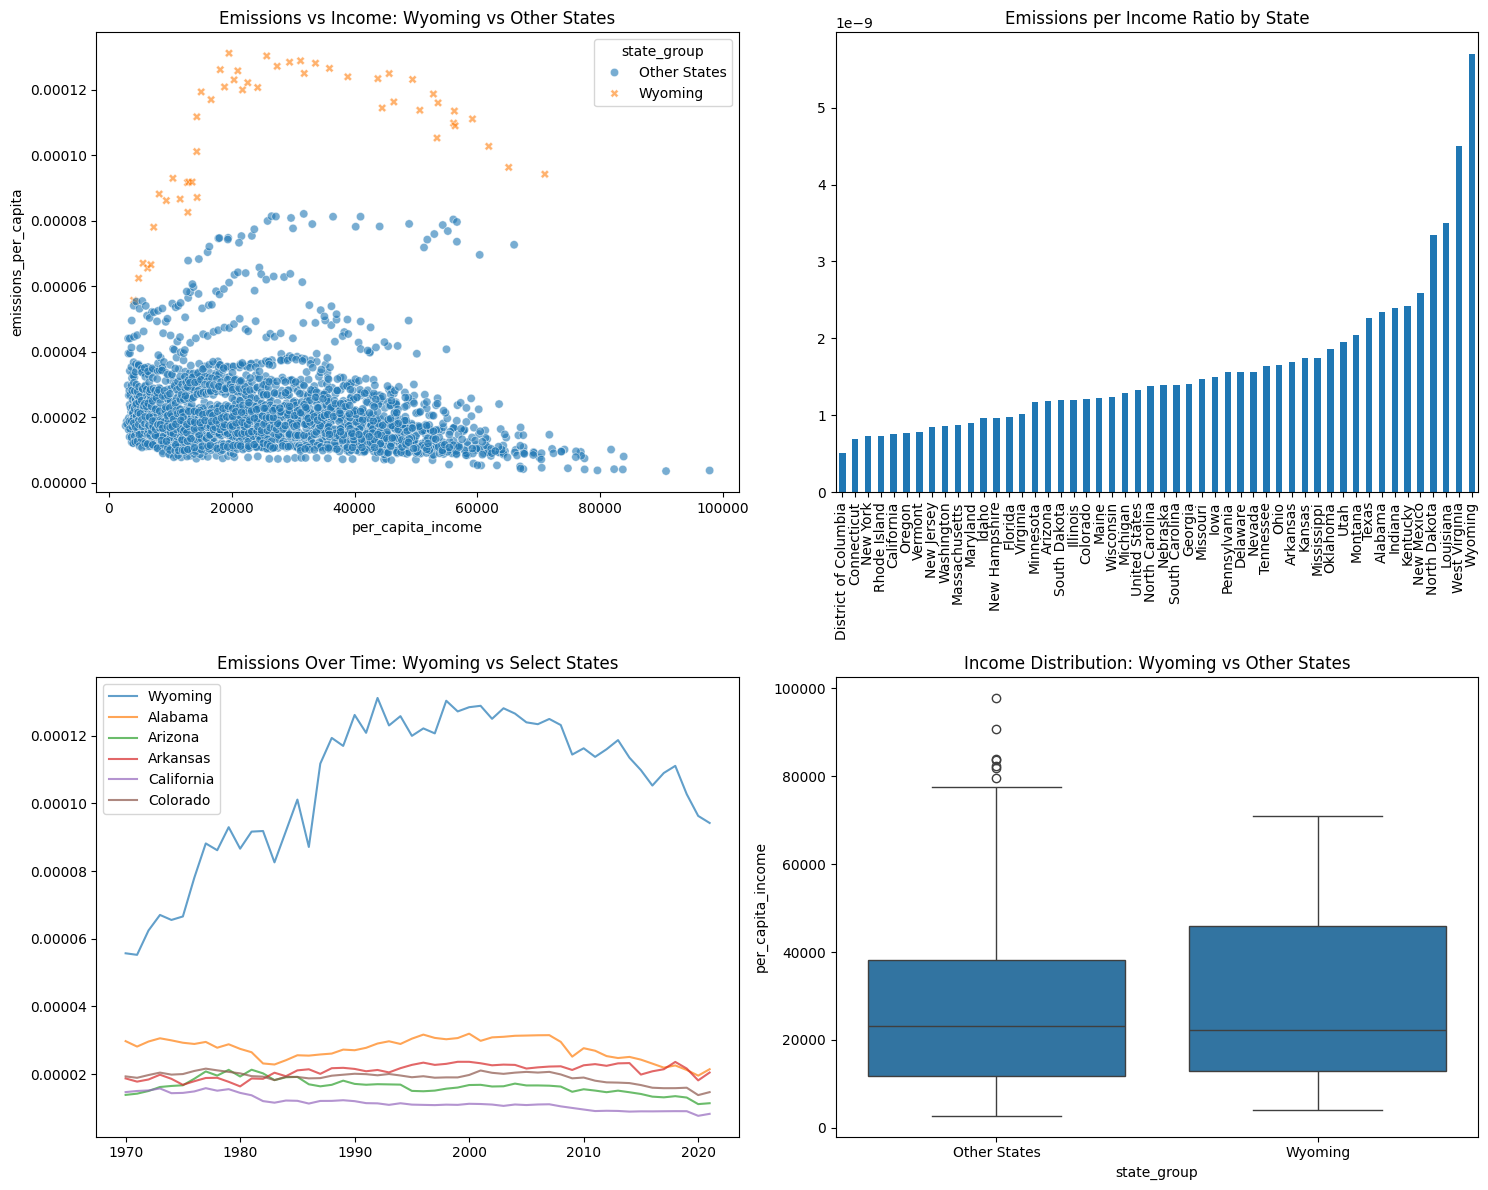

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_wyoming_patterns(df):
    """
    Analyze Wyoming's emissions and income patterns compared to other states
    """
    # Create comparison groups
    df['state_group'] = np.where(df['state'] == 'Wyoming', 'Wyoming', 'Other States')

    # Calculate key metrics
    metrics = pd.DataFrame()

    # For each state
    for state in df['state'].unique():
        state_data = df[df['state'] == state]

        # Calculate metrics
        metrics.loc[state, 'avg_emissions'] = state_data['emissions_per_capita'].mean()
        metrics.loc[state, 'avg_income'] = state_data['per_capita_income'].mean()
        metrics.loc[state, 'emissions_per_income'] = (state_data['emissions_per_capita'] /
                                                    state_data['per_capita_income']).mean()

    # Create visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Emissions vs Income Scatter
    sns.scatterplot(data=df, x='per_capita_income', y='emissions_per_capita',
                   hue='state_group', style='state_group',
                   alpha=0.6, ax=axes[0,0])
    axes[0,0].set_title('Emissions vs Income: Wyoming vs Other States')

    # 2. Emissions per Income Ratio
    metrics['emissions_per_income'].sort_values().plot(kind='bar', ax=axes[0,1])
    axes[0,1].set_title('Emissions per Income Ratio by State')
    axes[0,1].tick_labels = False

    # 3. Time Series of Emissions
    for state in ['Wyoming'] + list(df[df['state'] != 'Wyoming']['state'].unique())[:5]:
        state_data = df[df['state'] == state]
        axes[1,0].plot(state_data['year'], state_data['emissions_per_capita'],
                      label=state, alpha=0.7)
    axes[1,0].set_title('Emissions Over Time: Wyoming vs Select States')
    axes[1,0].legend()

    # 4. Income Distribution
    sns.boxplot(data=df, x='state_group', y='per_capita_income', ax=axes[1,1])
    axes[1,1].set_title('Income Distribution: Wyoming vs Other States')

    plt.tight_layout()

    # Print key findings
    print("\nKey Findings for Wyoming vs Other States:")
    print(f"Wyoming Average Emissions per Capita: {metrics.loc['Wyoming', 'avg_emissions']:.2f}")
    print(f"Other States Average Emissions per Capita: {metrics.loc[metrics.index != 'Wyoming', 'avg_emissions'].mean():.2f}")
    print(f"\nWyoming Average Income: ${metrics.loc['Wyoming', 'avg_income']:.2f}")
    print(f"Other States Average Income: ${metrics.loc[metrics.index != 'Wyoming', 'avg_income'].mean():.2f}")
    print(f"\nWyoming Emissions per Income Ratio: {metrics.loc['Wyoming', 'emissions_per_income']:.4f}")
    print(f"Other States Average Emissions per Income Ratio: {metrics.loc[metrics.index != 'Wyoming', 'emissions_per_income'].mean():.4f}")

    return fig, metrics

# Load and analyze data
df = pd.read_csv('processed_emissions_income.csv')
fig, metrics = analyze_wyoming_patterns(df)
plt.savefig('wyoming_analysis.png', dpi=300, bbox_inches='tight')
plt.show()